## Modelling a supervised Guesser

Modelling the unsupervised guesser and creating a synthetic dataset made me realize I could attempt making a supervised Guesser as well. Although there will be a lot of tradeoffs in terms of parallelization, pretraining, and clarity, hopefully it may in turn yield a better performance.

We can use word2vec once more to get semantic context features.

In [1]:
import decryptoai.word2vec_loader.loader as wv_loader

limit = 200_000
print(f"Loading {limit} keys")
google_news_wv = wv_loader.load_word2vec_keyedvectors(limit=limit, debug=True)

Loading 200000 keys


Let's take the synthetic dataset and make a training and test split. CHeckout the datamuse notebook if you haven't built it yet.

In [2]:
import decryptoai.config as cfg
import numpy as np
import pandas

meaning_df = pandas.read_csv(cfg.MEANING_CSV_PATH)
triggerword_df = pandas.read_csv(cfg.TRIGGERWORD_CSV_PATH)

# together there are about 70,000 samples
# if we save 80% for training and 20% for testing we get a similar split as MNIST
split_ratio = 0.8
meaning_split_index = int(len(meaning_df) * split_ratio)
triggerword_split_index = int(len(triggerword_df) * split_ratio)

meaning_train, meaning_test = meaning_df[:meaning_split_index], meaning_df[meaning_split_index:]
triggerword_train, triggerword_test = triggerword_df[:triggerword_split_index], triggerword_df[triggerword_split_index:]


train_df, test_df = pandas.concat([meaning_train, triggerword_train], axis=0), pandas.concat([meaning_test, triggerword_test], axis=0)

A naive way to encode each clue would be to put each keyword embedding followed by each clue embedding in order.

In [3]:
import torch


def features_to_tensor(features: pandas.Series):
    words_to_vecs = features.map(wv_loader.official_keyword_to_word).map(google_news_wv.__getitem__)
    return torch.from_numpy(np.array(words_to_vecs.tolist())).contiguous()

# initialize DataLoader
train_features, train_target = train_df.drop('code_index', axis=1), train_df['code_index']

# pytorch requires this to be Sequence of input, label pairs. If we can't store in RAM will make custom Dataset class
training_data = [((features_to_tensor(train_features.iloc[i][:4]), features_to_tensor(train_features.iloc[i][4:])), train_target.iloc[i]) for i in range(len(train_features))]

In [4]:
print(train_features.iloc[0])

keyword1     BUTTERFLY
keyword2       PLUMBER
keyword3          FOOT
keyword4         BLOOD
clue1           insect
clue2       bricklayer
clue3       foundation
Name: 0, dtype: object


We may use the negative log probability as the loss because we already found that it is a good metric for determining guesses with the unsupervised guesser. An architecture which uses sigmoids and convolutions should help the model come up with features resembling probabilistic quantities.

In [5]:
import os

torch.manual_seed(1337)
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=128, shuffle=True)

# instance, loss, optimizer
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# maximizing log-likelihood is a decent metric for this classification - see unsupervised notebook for more
loss_func = torch.nn.CrossEntropyLoss()

def train_loop(classifier, num_epochs=20, seed=1337):
    torch.manual_seed(seed)
    optimizer  = torch.optim.Adam(classifier.parameters(), lr=1e-5)
    for _ in range(num_epochs):
        for (K, C), y in train_dataloader: # loop through batches
            K, C = K.to(device), C.to(device)
            yhat = classifier(K, C)
            loss = loss_func(yhat, y)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        yield loss.item()

In [6]:
# dict for storing training losses of each model
import collections
training_losses = collections.defaultdict(list)

In [7]:
# adapted from MNIST example https://github.com/nicknochnack/PyTorchin15

class ClueClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(300, 256)
        self.c1 = torch.nn.Conv1d(256, 128, 2)
        self.l2 = torch.nn.Linear(128, 64)
        self.c2 = torch.nn.Conv1d(64, 32, 2)
        self.l3 = torch.nn.Linear(32, 16)
        self.c3 = torch.nn.Conv1d(16, 8, 2)
        self.l4 = torch.nn.Linear(32, 24)
        # 24 outputs = 4 permute 3 codes


    def forward(self, K, C):
        x = torch.concat((K, C), -2).to(device)
        x = torch.nn.functional.relu(self.l1(x))
        xt = x.transpose(-1, -2)
        x = torch.nn.functional.relu(self.c1(xt))
        xt = x.transpose(-1, -2)
        x = torch.nn.functional.relu(self.l2(xt))
        xt = x.transpose(-1, -2)
        x = torch.nn.functional.relu(self.c2(xt))
        xt = x.transpose(-1, -2)
        x = torch.nn.functional.relu(self.l3(xt))
        xt = x.transpose(-1, -2)
        x = torch.nn.functional.relu(self.c3(xt))
        x = x.flatten(1)
        x = torch.nn.functional.relu(self.l4(x))
        return x
    
classifier = ClueClassifier().to(device)

model_path = "model_state.pt"
if not os.path.exists(model_path):
    for epoch, loss in enumerate(train_loop(classifier)):
        training_losses["naive"].append(loss)
        print(f"Epoch {epoch} loss: {loss}")
    with open(model_path, 'wb') as f:
        torch.save(classifier.state_dict(), f)
else:
    with open(model_path, 'rb') as f:
        classifier.load_state_dict(torch.load(f))

Epoch 0 loss: 3.184074640274048
Epoch 1 loss: 3.1746420860290527
Epoch 2 loss: 3.183427095413208
Epoch 3 loss: 3.1809241771698
Epoch 4 loss: 3.185042142868042
Epoch 5 loss: 3.1814968585968018
Epoch 6 loss: 3.1795854568481445
Epoch 7 loss: 3.1910719871520996
Epoch 8 loss: 3.1883158683776855
Epoch 9 loss: 3.1775779724121094
Epoch 10 loss: 3.1805620193481445
Epoch 11 loss: 3.1844146251678467
Epoch 12 loss: 3.1778600215911865
Epoch 13 loss: 3.182830572128296
Epoch 14 loss: 3.1735007762908936
Epoch 15 loss: 3.1804006099700928
Epoch 16 loss: 3.172732353210449
Epoch 17 loss: 3.1752617359161377
Epoch 18 loss: 3.176784038543701
Epoch 19 loss: 3.1759088039398193


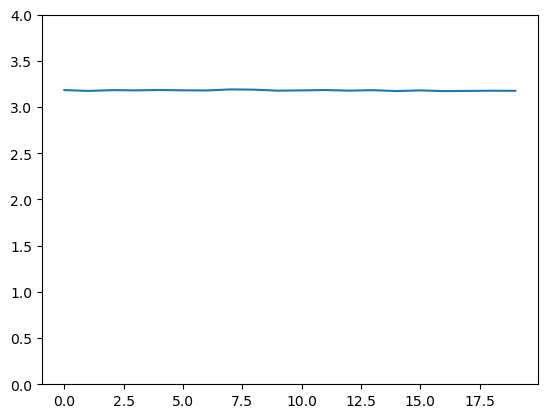

In [8]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.arange(len(training_losses["naive"]))
ypoints = np.array(training_losses["naive"])

ax = plt.gca()
ax.set_ylim([0, 4])

plt.plot(xpoints, ypoints)
plt.show()

In [9]:
test_features, test_target = test_df.drop('code_index', axis=1), test_df['code_index']
testing_data = [((features_to_tensor(test_features.iloc[i][:4]), features_to_tensor(test_features.iloc[i][4:])), test_target.iloc[i]) for i in range(len(test_features))]
with torch.no_grad():
    total = len(testing_data)
    correct = 0
    for (K, C), y in testing_data:
        out = classifier(K.unsqueeze(0), C.unsqueeze(0))
        guess = torch.argmax(torch.softmax(out, 0))
        correct += guess == y
print(len(testing_data))
print(correct / total)

14400
tensor(0.0417)


For each training epoch, the loss stayed around 3.17. As we can see, our model is having trouble learning.

We are asking it to do a lot. Not only are we asking it to come up with a maximum log probability guess, but we are implicitly asking it to learn the context of the game. Unlike the supervised guesser, our net knows nothing about how each keyword and clueword is related, or that the cluewords should be related to some of the keywords. Maybe there is an input format which will reflect this better.

What if instead of thinking of the input as a sequence 

```K1 K2 K3 K4 C1 C2 C3```

we thought of it as a matrix
```   
      C1      C2     C3
K1   K1C1    K1C2   K1C3

K2   K2C1    K2C2   K2C3

K3   K3C1    K3C2   K3C3

K4   K4C1    K4C2   K4C3

```

This encodes the input as keyword-clue pairs that the classifier may have an easier time learning associations for, because it explicitly establishes the keywords and clues as orthogonal. If we can build features for each keyword-clue pair, then this may allow us to build features representing 2 keyword-clue pairings, and even 3 keyword-clue pairings, which is exactly what our model should be learning to classify.

In [10]:
class ClueClassifierPairs(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(3 * 4 * 300, 1800)
        self.l2 = torch.nn.Linear(1800, 900)
        self.l3 = torch.nn.Linear(900, 450)
        self.l4 = torch.nn.Linear(450, 24)
        # 24 outputs = 4 permute 3 codes


    def forward(self, k: torch.Tensor, c: torch.Tensor):
        pairs = k.unsqueeze(-2) * c.unsqueeze(-3)
        x = pairs.flatten(-3)
        x = torch.nn.functional.relu(self.l1(x))
        x = torch.nn.functional.relu(self.l2(x))
        x = torch.nn.functional.relu(self.l3(x))
        x = torch.nn.functional.relu(self.l4(x))
        return x
    
classifier = ClueClassifierPairs().to(device)
optimizer  = torch.optim.Adam(classifier.parameters(), lr=1e-5)

# maximizing log-likelihood is a decent metric for this classification - see unsupervised notebook for more
loss_func = torch.nn.CrossEntropyLoss()



# train loop
model_path = "model_state_pairs.pt"
if not os.path.exists(model_path):
    for epoch, loss in enumerate(train_loop(classifier)):
        training_losses["pairs"].append(loss)
        print(f"Epoch {epoch} loss: {loss}")
    with open(model_path, 'wb') as f:
        torch.save(classifier.state_dict(), f)
else:
    with open(model_path, 'rb') as f:
        classifier.load_state_dict(torch.load(f))

Epoch 0 loss: 3.109863758087158
Epoch 1 loss: 2.501433849334717
Epoch 2 loss: 2.2803399562835693
Epoch 3 loss: 2.3245556354522705
Epoch 4 loss: 2.096872091293335
Epoch 5 loss: 2.0979433059692383
Epoch 6 loss: 2.1253561973571777
Epoch 7 loss: 2.120602607727051
Epoch 8 loss: 2.064939260482788
Epoch 9 loss: 2.1398000717163086
Epoch 10 loss: 1.9632827043533325
Epoch 11 loss: 2.0248703956604004
Epoch 12 loss: 2.049873113632202
Epoch 13 loss: 2.0359504222869873
Epoch 14 loss: 2.0691568851470947
Epoch 15 loss: 1.81076979637146
Epoch 16 loss: 1.9572396278381348
Epoch 17 loss: 2.1670713424682617
Epoch 18 loss: 1.7167640924453735
Epoch 19 loss: 1.6997170448303223


In [11]:
test_features, test_target = test_df.drop('code_index', axis=1), test_df['code_index']
testing_data = [((features_to_tensor(test_features.iloc[i][:4]), features_to_tensor(test_features.iloc[i][4:])), test_target.iloc[i]) for i in range(len(test_features))]
with torch.no_grad():
    total = len(testing_data)
    correct = 0
    for (K, C), y in testing_data:
        out = classifier(K, C)
        guess = torch.argmax(torch.softmax(out, 0))
        correct += guess == y
print(len(testing_data))
print(correct / total)

14400
tensor(0.4150)


A substantial improvement! We should be careful with the multiplication because softmax is sensitive. If the values are too small it may be too uniform, and if they are too large it may give an output like a one-hot encoding. It would be worth scaling the inputs such that their variance is about 1 if they aren't already.

In [12]:
k, c = next(iter(train_dataloader))[0]
print(k.var(), c.var(), (k.unsqueeze(-2) * c.unsqueeze(-3)).var())


tensor(0.0330) tensor(0.0378) tensor(0.0014)


Notice that the values get smaller by a couple orders of magnitude, and that's just for this example. Let's adjust the variance with a simple scalar.

In [13]:
print(np.array([(google_news_wv[i]).var() for i in range(200_000)]).mean())
print(1 / (300 ** 0.5))

0.056122936
0.05773502691896257


I don't want to prove it but these numbers are suspiciously close. I'm going to assume the constant I should scale by informed by this.

In [14]:
class ClueClassifierPairsNormalized(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(3 * 4 * 300, 1800)
        self.l2 = torch.nn.Linear(1800, 900)
        self.l3 = torch.nn.Linear(900, 450)
        self.l4 = torch.nn.Linear(450, 24)
        # 24 outputs = 4 permute 3 codes


    def forward(self, k: torch.Tensor, c: torch.Tensor):
        pairs = k.unsqueeze(-2) * c.unsqueeze(-3) * (300 ** 0.5)
        x = pairs.flatten(-3)
        x = torch.nn.functional.relu(self.l1(x))
        x = torch.nn.functional.relu(self.l2(x))
        x = torch.nn.functional.relu(self.l3(x))
        x = torch.nn.functional.relu(self.l4(x))
        return x
    
classifier = ClueClassifierPairsNormalized().to(device)
optimizer  = torch.optim.Adam(classifier.parameters(), lr=1e-5)

# maximizing log-likelihood is a decent metric for this classification - see unsupervised notebook for more
loss_func = torch.nn.CrossEntropyLoss()



# train loop
model_path = "model_state_pairs_normalized.pt"
if not os.path.exists(model_path):
    for epoch, loss in enumerate(train_loop(classifier)):
        training_losses["pairs_normalized"].append(loss)
        print(f"Epoch {epoch} loss: {loss}")

    with open(model_path, 'wb') as f:
        torch.save(classifier.state_dict(), f)
else:
    with open(model_path, 'rb') as f:
        classifier.load_state_dict(torch.load(f))

Epoch 0 loss: 2.346200704574585
Epoch 1 loss: 1.763702154159546
Epoch 2 loss: 1.5686112642288208
Epoch 3 loss: 1.4595974683761597
Epoch 4 loss: 1.3134533166885376
Epoch 5 loss: 1.3430025577545166
Epoch 6 loss: 1.1300344467163086
Epoch 7 loss: 1.064315676689148
Epoch 8 loss: 1.176363468170166
Epoch 9 loss: 1.0821633338928223
Epoch 10 loss: 1.0519684553146362
Epoch 11 loss: 0.935781717300415
Epoch 12 loss: 1.2319140434265137
Epoch 13 loss: 1.0454274415969849
Epoch 14 loss: 0.9662264585494995
Epoch 15 loss: 0.8441006541252136
Epoch 16 loss: 0.997769832611084
Epoch 17 loss: 0.9108225703239441
Epoch 18 loss: 0.6846254467964172
Epoch 19 loss: 0.6707579493522644


In [15]:
test_features, test_target = test_df.drop('code_index', axis=1), test_df['code_index']
testing_data = [((features_to_tensor(test_features.iloc[i][:4]), features_to_tensor(test_features.iloc[i][4:])), test_target.iloc[i]) for i in range(len(test_features))]
with torch.no_grad():
    total = len(testing_data)
    correct = 0
    for (K, C), y in testing_data:
        out = classifier(K, C)
        guess = torch.argmax(torch.softmax(out, 0))
        correct += guess == y
print(len(testing_data))
print(correct / total)

14400
tensor(0.6111)


Even though the introduction of the matrix abstraction allows the feed forward network to build features based off each keyword-clue pair, the multiplication aspect is fixed. The model has no room to learn how much each channel should contribute to each product, or how keywords contribute differently from cluewords. Introducing a simple layer before the operation should allow for this.

In [16]:
class ClueClassifierKeyCluePairs(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.k = torch.nn.Linear(300, 300)
        self.c = torch.nn.Linear(300, 300)
        self.l1 = torch.nn.Linear(3 * 4 * 300, 1800)
        self.l2 = torch.nn.Linear(1800, 900)
        self.l3 = torch.nn.Linear(900, 450)
        self.l4 = torch.nn.Linear(450, 24)
        # 24 outputs = 4 permute 3 codes


    def forward(self, k: torch.Tensor, c: torch.Tensor):
        k = self.k(k)
        c = self.c(c)
        pairs = k.unsqueeze(-2) * c.unsqueeze(-3) * 85
        x = pairs.flatten(-3)
        x = torch.nn.functional.relu(self.l1(x))
        x = torch.nn.functional.relu(self.l2(x))
        x = torch.nn.functional.relu(self.l3(x))
        x = torch.nn.functional.relu(self.l4(x))
        return x
    
classifier = ClueClassifierKeyCluePairs().to(device)
optimizer  = torch.optim.Adam(classifier.parameters(), lr=1e-5)

# maximizing log-likelihood is a decent metric for this classification - see unsupervised notebook for more
loss_func = torch.nn.CrossEntropyLoss()

# train loop
model_path = "model_state_key_clue_pairs.pt"
if not os.path.exists(model_path):
    for epoch, loss in enumerate(train_loop(classifier)):
        training_losses["key_clue_pairs"].append(loss)
        print(f"Epoch {epoch} loss: {loss}")
    with open(model_path, 'wb') as f:
        torch.save(classifier.state_dict(), f)
else:
    with open(model_path, 'rb') as f:
        classifier.load_state_dict(torch.load(f))

Epoch 0 loss: 3.1793270111083984
Epoch 1 loss: 3.1375420093536377
Epoch 2 loss: 1.1790896654129028
Epoch 3 loss: 0.39304831624031067
Epoch 4 loss: 0.2604251801967621
Epoch 5 loss: 0.20799697935581207
Epoch 6 loss: 0.20477299392223358
Epoch 7 loss: 0.09832645952701569
Epoch 8 loss: 0.13844120502471924
Epoch 9 loss: 0.18248754739761353
Epoch 10 loss: 0.10458698868751526
Epoch 11 loss: 0.10495375096797943
Epoch 12 loss: 0.08463545888662338
Epoch 13 loss: 0.22556006908416748
Epoch 14 loss: 0.1013873741030693
Epoch 15 loss: 0.20006170868873596
Epoch 16 loss: 0.050872448831796646
Epoch 17 loss: 0.12492848187685013
Epoch 18 loss: 0.22781656682491302
Epoch 19 loss: 0.22396501898765564


In [17]:
test_features, test_target = test_df.drop('code_index', axis=1), test_df['code_index']
testing_data = [((features_to_tensor(test_features.iloc[i][:4]), features_to_tensor(test_features.iloc[i][4:])), test_target.iloc[i]) for i in range(len(test_features))]
with torch.no_grad():
    total = len(testing_data)
    correct = 0
    for (K, C), y in testing_data:
        out = classifier(K, C)
        guess = torch.argmax(torch.softmax(out, 0))
        correct += guess == y
print(len(testing_data))
print(correct / total)

14400
tensor(0.9378)


That's pretty great; it blows our unsupervised guessers out of the water. It may even be to the point of starting to learn the biases of the synthetic dataset. Let's compare the training loss for each of our models.

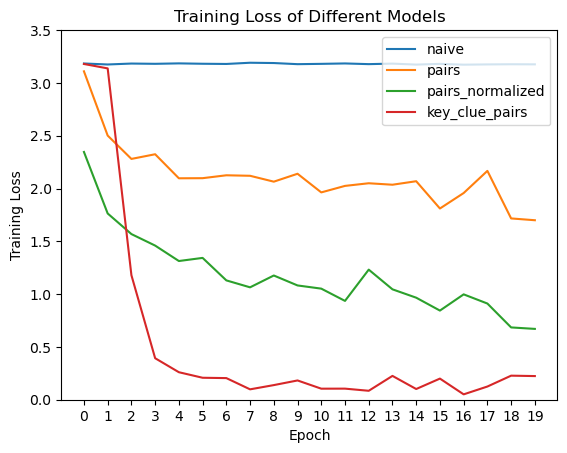

In [23]:
for model_name, losses in training_losses.items():
    plt.plot(losses, label=model_name)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss of Different Models')
plt.legend(loc="upper right")

plt.xticks(list(range(20)))
ax = plt.gca()
ax.set_ylim([0, 3.5])

plt.show()


However, this model scales pretty terribly.

In [19]:
print(sum(p.numel() for p in classifier.parameters()))

8699574


This has almost 9M parameters for only 7 input words, or 7 * 300 = 2100 features if we consider the Google News embeddings. This is mostly attributed to the matrix idea from earlier; we are essentially squaring the number of features by introducing this idea.